In [1]:
#Hyperparameters:

SHOULD_USE_SEED = True
RADIUS = 5000
BATCH_SIZE = 700
EPSILON = 0.1
SIGMA = 0.001
MAX_ITERS = 100

NN_BATCH_SIZE = 128

TRAIN_FILE = "esnli_train.csv"
VAL_FILE = "esnli_dev.csv"
TEST_FILE = "esnli_test.csv"


In [2]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import numpy as np

from data.data_creator import data_create_SNLI

if SHOULD_USE_SEED:
    np.random.seed(42)


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset 

In [4]:
data, labels = data_create_SNLI()

In [5]:
#Splitting the dataset by using the original split

x_train, x_val, x_test = data[TRAIN_FILE], data[VAL_FILE], data[TEST_FILE]
y_train, y_val, y_test = labels[TRAIN_FILE], labels[VAL_FILE], labels[TEST_FILE]

## Black-box model - Multinomial Naive Bayes classifier

The black box model that was used in the original article.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

data_multinomial_nb = dict()

for key in data:
    data_multinomial_nb[key] = \
        [first + '~ ' + second for first, second in zip(data[key]['premise'], data[key]['hypothesis'])]
    
x_train, x_val, x_test = data_multinomial_nb[TRAIN_FILE], data_multinomial_nb[VAL_FILE], data_multinomial_nb[TEST_FILE]

vect_text = TfidfVectorizer(use_idf = False)
x_vec_train = vect_text.fit_transform(x_train)

clf = MultinomialNB().fit(x_vec_train, y_train)

In [7]:
preds = clf.predict(vect_text.transform(x_val))

In [8]:
print('Val accuracy', metrics.accuracy_score(y_val, preds))

Val accuracy 0.5420646210119894


## Black-box model - Neural Network

The black box model above doesn't give a good result. Therefore, we use another black box model presented in the following article:
https://nlp.stanford.edu/pubs/snli_paper.pdf

### Data preperation


In [9]:
#https://jamesmccaffrey.wordpress.com/2021/01/04/creating-a-custom-torchtext-dataset-from-a-text-file/

from torchtext.legacy.data import Field
import torchtext as tt

TEXT = tt.legacy.data.Field(sequential=True,
  init_token='(bos)',  # start of sequence
  eos_token='(eos)',   # replace parens with less, greater
  lower=True,
  tokenize=tt.data.utils.get_tokenizer("basic_english"),)
LABEL = tt.legacy.data.Field(sequential=False,
  use_vocab=True,
  unk_token=None,
  is_target=True)

In [10]:
import os

(train_obj, valid_obj, test_obj) = tt.legacy.data.TabularDataset.splits(
  path=".//data/eSNLI/",
  train=TRAIN_FILE,
  validation=VAL_FILE,
  test=TEST_FILE,
  skip_header = True,
  format='csv',
  filter_pred = lambda x: x.gold_label != '-',
    #gold_label	sentence1_binary_parse	sentence2_binary_parse	sentence1_parse	sentence2_parse	sentence1	sentence2	captionID	pairID	label1	label2	label3	label4	label5
  fields=[('pairID', None), ('gold_label', LABEL), ('sentence1', TEXT), ('sentence2', TEXT)])#, ('sentence1_binary_parse', None), ('sentence2_binary_parse', None), 
          #('sentence1_parse', None), ('sentence1_parse', None), ('captionID', None), 
         #('pairID', None), ('label1', None), ('label2', None), ('label3', None), ('label4', None), ('label5', None)])

In [11]:
TEXT.build_vocab(train_obj.sentence1, min_freq=1, vectors='glove.6B.300d')
TEXT.build_vocab(train_obj.sentence2, min_freq=1, vectors='glove.6B.300d')
LABEL.build_vocab(train_obj.gold_label)
pretrained_embeddings = TEXT.vocab.vectors

In [12]:
train_iter, val_iter, test_iter = tt.legacy.data.BucketIterator.splits(
   (train_obj, valid_obj, test_obj), 
    batch_size=NN_BATCH_SIZE, 
    sort_key = lambda x: len(x.sentence1),
    sort_within_batch = False,
    repeat=False, 
    device=device)

In [13]:
# #TODO: Should be in separat file!
# import torch
# import torch.nn as nn
# from tqdm import tqdm
# import copy

# class NeuralNetModel (nn.Module):
#     def __init__(self, hidden_size, embeddings, embeddings_size, num_layers, text, tag, num_classes = 3, verbose = True):
#         super().__init__()
#         self.text = text
#         self.tag = tag
#         self.N = len(tag.vocab.itos)   # tag vocab size
#         self.V = len(text.vocab.itos)  # text vocab size
#         self.verbose = verbose

#         pad_id = self.text.vocab.stoi[self.tag.pad_token]
#         self.loss_function = nn.CrossEntropyLoss()

#         self.premise_layer = nn.Sequential(
#             nn.Embedding.from_pretrained(embeddings = embeddings, freeze = True),
#             nn.LSTM(input_size = embeddings_size, hidden_size = hidden_size, num_layers=num_layers, batch_first=True)
#         )
#         self.hypothesis_layer = nn.Sequential(
#             nn.Embedding.from_pretrained(embeddings = embeddings, freeze = True),
#             nn.LSTM(input_size = embeddings_size, hidden_size = hidden_size, num_layers=num_layers, batch_first=True)
#         )
#         self.model_layers = nn.Sequential(
#             nn.Linear(hidden_size*2, 200),
#             nn.Tanh(),
#             nn.Linear(200, 200),
#             nn.Tanh(),
#             nn.Linear(200, 200),
#             nn.Tanh(),
#             nn.Linear(200, num_classes),
#             nn.Softmax(dim = -1)
#         )
#         self.log_soft_max = nn.LogSoftmax(dim = -1)

# #     def init_parameters(self, init_low=-0.5, init_high=0.5):
# #         """Initialize parameters. We usually use larger initial values for smaller models.
# #         See http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf for a more
# #         in-depth discussion.
# #         """
# #         for p in self.parameters():
# #             p.data.uniform_(init_low, init_high)
        
#     def forward(self, premise_batch, hypothesis_batch):
#         """Performs forward computation over a whole text_batch, returns logits.

#         Arguments: 
#           text_batch: a tensor of size max_length x batch_size
#           hidden_0: a tensor of size 1 x batch_size x hidden_size
#         Returns:
#           logits: a tensor of size max_length x batch_size x N. It provides a logit for each tag of each word of each sentence
#           in the batch.
#         """
#         premise_batch = premise_batch.T
#         hypothesis_batch = hypothesis_batch.T
#         _, (premise_layer_output, _) = self.premise_layer(premise_batch)
#         _, (hypothesis_layer_output, _) = self.hypothesis_layer(hypothesis_batch)
#         premise_layer_output = premise_layer_output[-1, :, :].squeeze(0)
#         hypothesis_layer_output = hypothesis_layer_output[-1, :, :].squeeze(0)
#         if (len(premise_layer_output.shape) == 1):
#             premise_layer_output = premise_layer_output.unsqueeze(0)
#         if (len(hypothesis_layer_output.shape) == 1):
#             hypothesis_layer_output = hypothesis_layer_output.unsqueeze(0)
#         #print(premise_layer_output.shape)
#         concat_output = torch.cat((premise_layer_output, hypothesis_layer_output), dim = 1)
#         #print(concat_output.shape)
#         res = self.model_layers(concat_output)
#         logits = self.model_layers(concat_output)
#         #print(logits)
#         return logits

#     '''
#        Computes the loss for a batch by comparing logits of a batch returned by forward to ground_truth, 
#        which stores the true tag ids for the batch. Thus logits is a tensor of size max_length x batch_size x N, 
#        and ground_truth is a tensor of size max_length x batch_size. Note that the criterion functions in torch expect 
#        outputs of a certain shape, so you might need to perform some shape conversions.

#        You might find nn.CrossEntropyLoss from the last project segment useful. 
#        Note that if you use nn.CrossEntropyLoss then you should not use a softmax layer at the end since that's 
#        already absorbed into the loss function. Alternatively, you can use nn.LogSoftmax as the final sublayer 
#        in the forward pass, but then you need to use nn.NLLLoss, which does not contain its own softmax.
#        We recommend the former, since working in log space is usually more numerically stable. 
#        For reshaping tensors, check out the torch.Tensor.view method.
#     '''
#     def compute_loss(self, logits, ground_truth):
#         return self.loss_function(logits, ground_truth.view(-1))

#     '''
#       Trains the model on training data generated by the iterator train_iter and validation data val_iter.
#       The epochs and learning_rate variables are the number of epochs (number of times to run through the training data) 
#       to run for and the learning rate for the optimizer, respectively. You can use the validation data to determine 
#       which model was the best one as the epochs go by. Notice that our code below assumes that during training 
#       the best model is stored so that rnn_tagger.load_state_dict(rnn_tagger.best_model) restores the 
#       parameters of the best model.
#     '''
    
#     def train_all(self, train_iter, val_iter, epochs=100, learning_rate=0.001):
#         # Switch the module to training mode
#         self.train()
#         # Use Adam to optimize the parameters
#         optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
#         best_validation_accuracy = -float('inf')
#         best_model = None
#         # Run the optimization for multiple epochs
#         for epoch in range(epochs): 
#             total = 0
#             running_loss = 0.0
#             for batch in tqdm(train_iter, leave=self.verbose):
#                 # Zero the parameter gradients
#                 self.zero_grad()

#                 # Input and target
#                 premises = batch.sentence1
#                 hypothesis = batch.sentence2 
#                 tags = batch.gold_label
#                 # Run forward pass and compute loss along the way.
                
#                 logits = self.forward(premises, hypothesis)
#                 #print(logits.shape)
#                 loss = self.compute_loss(logits, tags)

# #                 # Perform backpropagation
# #                 print(logits)
# #                 print(tags)
# #                 print("#############################################################")
#                 (loss/premises.size(1)).backward()
#                 #print(loss)

#                 # Update parameters
#                 optim.step()

#                 # Training stats
#                 total += 1
#                 running_loss += loss.item()
                
#             # Evaluate and track improvements on the validation dataset
#             validation_accuracy = self.evaluate(val_iter)
#             if validation_accuracy > best_validation_accuracy:
#                 best_validation_accuracy = validation_accuracy
#                 self.best_model = copy.deepcopy(self.state_dict())
#             epoch_loss = running_loss / total
#             if (self.verbose):
#                 print (f'Epoch: {epoch} Loss: {epoch_loss:.4f} '
#                       f'Validation accuracy: {validation_accuracy:.4f}')

            
#     def predict(self, text_batch):
#         """Returns the most likely sequence of tags for a sequence of words in `text_batch`.

#         Arguments: 
#           text_batch: a tensor containing word ids of size (seq_len, batch_size) 
#         Returns:
#           tag_batch: a tensor containing tag ids of size (seq_len, batch_size)
#         """
#         logits = self.forward(text_batch.sentence1, text_batch.sentence2)
#         #print(logits)
#         tag_batch = torch.argmax(logits, axis = -1)
#         return tag_batch
    
#     def predict_proba(self, text_batch):
#         """Returns the most likely sequence of tags for a sequence of words in `text_batch`.

#         Arguments: 
#           text_batch: a tensor containing word ids of size (seq_len, batch_size) 
#         Returns:
#           tag_batch: a tensor containing tag ids of size (seq_len, batch_size)
#         """
#         if (text_batch is list):
#             print(":)")
#         logits = self.forward(text_batch.sentence1, text_batch.sentence2).detach().cpu().numpy()
#         return logits


#     def evaluate(self, iterator):
#         """Returns the model's performance on a given dataset `iterator`.

#         Arguments: 
#           iterator
#         Returns:
#           overall accuracy
#         """
#         correct = 0
#         total = 0
#         pad_id = self.text.vocab.stoi[self.tag.pad_token]
#         for batch in tqdm(iterator, leave = self.verbose):
#             premises = batch.sentence1
#             hypothesis = batch.sentence2 
#             tags = batch.gold_label
#             # Run forward pass and compute loss along the way.
                
#             #logits = self.forward(premises, hypothesis)
#             #tags = batch.tag
#             tags_pred = self.predict(batch)
#             mask = tags.ne(pad_id)
#             cor = (tags == tags_pred)[mask]
#             correct += cor.float().sum().item()
#             total += mask.float().sum().item()
#         return correct/total


### Building the model

In [15]:
from black_box_models.neural_network import NeuralNetModel

clf = NeuralNetModel(100, pretrained_embeddings, 300, 1, TEXT, LABEL).to(device)

In [16]:
LABEL.vocab.itos

['entailment', 'contradiction', 'neutral']

In [17]:
clf.train_all(train_iter, val_iter, epochs = 10)

  0%|          | 0/2032 [00:00<?, ?it/s]

Epoch: 0 Loss: 1.0010 Validation accuracy: 0.5437


  0%|          | 0/2032 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.9324 Validation accuracy: 0.5346


  0%|          | 0/2032 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.9082 Validation accuracy: 0.6020


  0%|          | 0/2032 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.8948 Validation accuracy: 0.4836


  0%|          | 0/2032 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.8855 Validation accuracy: 0.6406


  0%|          | 0/2032 [00:00<?, ?it/s]

Epoch: 5 Loss: 0.8769 Validation accuracy: 0.5673


  0%|          | 0/2032 [00:00<?, ?it/s]

Epoch: 6 Loss: 0.8709 Validation accuracy: 0.6578


  0%|          | 0/2032 [00:00<?, ?it/s]

Epoch: 7 Loss: 0.8642 Validation accuracy: 0.5933


  0%|          | 0/2032 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.8583 Validation accuracy: 0.6427


100%|██████████| 77/77 [00:00<00:00, 251.15it/s]

Epoch: 9 Loss: 0.8554 Validation accuracy: 0.6591


## Instance to explain

In [18]:
def convert_tensor_to_text (t , FIELD):
    if (t.dim() == 0):
        return FIELD.vocab.itos[t.item()]
    return ' '.join([FIELD.vocab.itos[i] for i in t])

In [19]:
batch = next(iter(train_iter))

def create_tensor_from_sentence(sentence):
    length = len(tokenizer(sentence)) + 2
    pad_id = TEXT.vocab.stoi[TEXT.pad_token]
    init_id = TEXT.vocab.stoi[TEXT.init_token]
    eos_id = TEXT.vocab.stoi[TEXT.eos_token]
    tensor = torch.ones((2,), dtype=torch.int64)
    t = tensor.new_full(size = (length, 1), fill_value  = pad_id, device = device)
    t[0, 0] = init_id
    tokens_idx = torch.LongTensor([TEXT.vocab.stoi[token] for token in tokenizer(sentence)])
    t[1 : len(tokens_idx) + 1, 0] = tokens_idx
    t[len(tokens_idx) + 1, 0] = eos_id
    return t

class Instance:
    
    def __init__(self, sentence1, sentence2):
        self.sentence1 = sentence1
        self.sentence2 = sentence2

def transform_func(x):
    splitted_x = x.split('*')
    premise = splitted_x[0]
    hypothesis = splitted_x[1]
    t_premise = create_tensor_from_sentence(premise)
    t_hypothesis = create_tensor_from_sentence(hypothesis)
#     print(t_premise)
#     print(t_hypothesis)
#     print(premise)
#     print(hypothesis)
    return Instance(t_premise, t_hypothesis)
    #return vect_text.transform([x])


In [20]:
# batch = next(iter(train_iter))
# print('premise to explain: ',convert_tensor_to_text(batch.sentence1[:, 0], TEXT))
# print('hypothesis to explain: ',convert_tensor_to_text(batch.sentence2[:, 0], TEXT))
# print('Predicted class: ', convert_tensor_to_text(clf.predict(batch)[0], LABEL))
# print('True class: ', convert_tensor_to_text(batch.gold_label[0], LABEL))
def tokenizer(x):
#     if '*' in x:
#         x = x.split('*')
#         return x[0].split() + x[1].split()
    return x.split()


for idx in range(len(x_test)):
    x_explain = x_test[idx]#"the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing ."
    premise = x_test[idx].split('~')[0]
    hypothesis = x_test[idx].split('~')[1]
#     
    x_explain = premise + " * " + hypothesis 
    if(convert_tensor_to_text(clf.predict(transform_func(x_explain))[0], LABEL) == y_test[idx] and y_test[idx] != 'neutral'):
        print('premise to explain: ', premise)
        print('hypothesis to explain: ',hypothesis)
        print('Predicted class: ', convert_tensor_to_text(clf.predict(transform_func(x_explain))[0], LABEL))
        print('True class: ', y_test[idx])
        break




premise to explain:  This church choir sings to the masses as they sing joyous songs from the book at a church.
hypothesis to explain:   A choir singing at a baseball game.
Predicted class:  contradiction
True class:  contradiction


## Building MeLime model:

In [21]:
import nltk
from torch.utils.data import DataLoader

dl_train = [tokenizer(x) for x in x_train]

In [22]:
from gen_models.word2vec_gen import Word2VecGen, Word2VecEncoder
#The radius is <radius> most similar words
encoder = Word2VecEncoder(dl_train)
generator = Word2VecGen(encoder = encoder, corpus = x_train, radius = RADIUS, tokenizer = tokenizer,
                       tokens_not_to_sample = ['*', '.', 'a'])

In [23]:
from interpretable_local_models.statistics_model_nli import StatisticsLocalModelNLI
y_p_explain = max(clf.predict_proba(transform_func(x_explain))[0]).item()
print('Probability for the predicted label: ', y_p_explain)
# print('The tokenized hypothesis:')

# tokenized_x_explain_premise = tokenizer(convert_tensor_to_text(batch.sentence1[:, 0], TEXT))
# tokenized_x_explain_hypothesis = tokenizer(convert_tensor_to_text(batch.sentence2[:, 0], TEXT))
# fliter_out_tokens = [TEXT.pad_token, TEXT.init_token, TEXT.eos_token]
# tokenized_x_explain_hypothesis = list(filter(lambda x: x not in fliter_out_tokens, tokenized_x_explain_hypothesis))
# tokenized_x_explain_premise = list(filter(lambda x: x not in fliter_out_tokens, tokenized_x_explain_premise))
# print(tokenized_x_explain_hypothesis)
# x_explain_hypothesis = ' '.join(tokenized_x_explain_hypothesis)
# x_explain_premise = ' '.join(tokenized_x_explain_premise)

# x_explain = x_explain_premise + " * " + x_explain_hypothesis
# print(x_explain)
print(tokenizer(x_explain))
print(tokenizer(premise))
explainer_model = StatisticsLocalModelNLI(y_p_explain, len(tokenizer(x_explain)), tokenizer, 
                                       len(tokenizer(premise)))


Probability for the predicted label:  0.8878218531608582
['This', 'church', 'choir', 'sings', 'to', 'the', 'masses', 'as', 'they', 'sing', 'joyous', 'songs', 'from', 'the', 'book', 'at', 'a', 'church.', '*', 'A', 'choir', 'singing', 'at', 'a', 'baseball', 'game.']
['This', 'church', 'choir', 'sings', 'to', 'the', 'masses', 'as', 'they', 'sing', 'joyous', 'songs', 'from', 'the', 'book', 'at', 'a', 'church.']


In [24]:
from MeLime.model import MeLimeModel
from torch import tensor


model = MeLimeModel(black_box_model = clf,gen_model =generator, batch_size = BATCH_SIZE, epsilon_c = EPSILON, 
                    sigma = SIGMA, explainer_model = explainer_model, transform_func = transform_func, 
                    max_iters = MAX_ITERS, tokenizer = tokenizer)
        


## Explaining the instance

In [25]:
res, sentences_with_probs = model.forward(x_explain)

Iteration number:  3
Delta:  0.004232186525147507
Iteration number:  6
Delta:  0.0014156065364810838
Iteration number:  9
Delta:  0.0005386814034306841


## Plotting results

/home/ortalcohen/NLP-Project/NLP-Seminar/interpretable_local_models/statistics_model_nli.py:84: RuntimeWarning: invalid value encountered in double_scalars
  x = x / abs(x) * 0.10


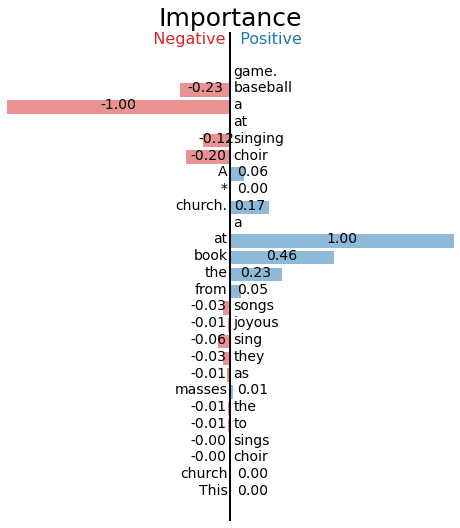

In [26]:
ax = StatisticsLocalModelNLI.plot_explaination(res)


Premise plot:


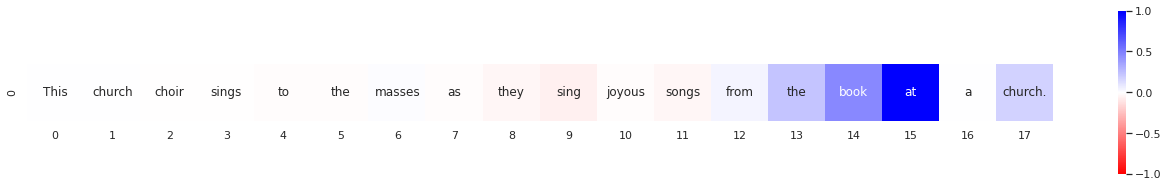

In [27]:
import seaborn as sns
premise_res = []
hypothesis_res = []
did_finish_premise = False
for word, stat in res:
    if word == '*':
        did_finish_premise = True
        continue
    if did_finish_premise:
        hypothesis_res.append((word, stat))
        continue
    premise_res.append((word, stat))
print("Premise plot:")
StatisticsLocalModelNLI.plot_sentence_heatmap(premise_res)


Hypothesis plot:


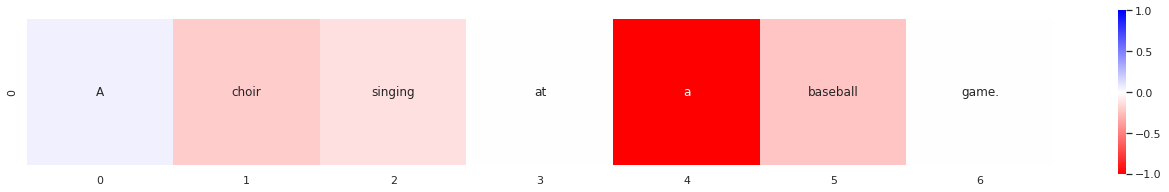

In [28]:
print("Hypothesis plot:")
StatisticsLocalModelNLI.plot_sentence_heatmap(hypothesis_res)

## Plotting most favorable and contrary samples phrases:

Favorable sentence - a generated sentence using Word2VecGen that improves the model's confidence in its 
prediction on the original sentence.

Contrary samples - a generated sentence using Word2VecGen that decrease the model's confidence in its prediction on the original sentence and <b>might even change its prediction on the generated sentence</b>.

### Most contrary samples phrases:



In [29]:
sorted(sentences_with_probs, key = lambda x: x[1])[:5]

[('This church choir sings to the masses as they sing joyous songs from the book at a church. * A choir singing at a anticipate game.',
  0.00013531352),
 ('This church choir sings to the masses as they sing joyous songs from the book at a church. * A choir singing at a buzz game.',
  0.00015297391),
 ('This church choir sings to the masses as they sing joyous songs from the book at a church. * A choir singing at a joyfully game.',
  0.00015378332),
 ('This church choir sings to the masses as they sing joyous songs from the book at a church. * A choir singing at a pro game.',
  0.00021330966),
 ('This church choir sings to the masses as they sing joyous songs from the book at a church. * A choir singing at a birthdays game.',
  0.00024543423)]

### Most favorable samples phrases:

In [30]:
sorted(sentences_with_probs, key = lambda x: x[1], reverse = True)[:5]

[('This church choir sings to the masses as they sing joyous songs from the book at a church. * A cats singing at a baseball game.',
  0.9998148),
 ('This church choir sings to the masses as they sing joyous songs from the book at a church. * naked choir singing at a baseball game.',
  0.9998024),
 ('This church choir sings to the masses as they sing joyous songs from the book at a church. * A choir singing alone a baseball game.',
  0.99973446),
 ('This church choir sings to the masses as they sing joyous songs from the book at a church. * A raid singing at a baseball game.',
  0.99954236),
 ('This church choir sings to the masses as they sing joyous songs from the book at a church. * A piranha singing at a baseball game.',
  0.99936765)]

In [ ]:
from MeLime.measures import calc_f1_esnli

F1_score = calc_f1_esnli(convert_tensor_to_text, clf, transform_func, LABEL, y_p_explain, tokenizer, encoder, 
                                          x_train, RADIUS, BATCH_SIZE, EPSILON, SIGMA, MAX_ITERS, None)
print("F1 score: ", F1_score)

In [ ]:
# import pandas as pd
# from os.path import isfile, join

# # Getting gold explanations:
# df = pd.read_csv(join("data/eSNLI", 'esnli_test.csv'))

In [ ]:
# def get_sentence_explanation(df, num):
#     x_explain = []
#     for i in range(len(df['Sentence' + str(num) + '_Highlighted_1'])):
#         res = None
#         for t in ['1', '2', '3']:
#             x = df['Sentence' + str(num) + '_Highlighted_'+t][i]
#             if x == '{}':
#                 res = set()
#             else:
#                 if res == None:
#                     res = set(map(int, x.split(',')))
#                     continue
#                 res = res.intersection(set(map(int, x.split(','))))
#         x_explain.append(res)
#     return x_explain

# premise_explanations = get_sentence_explanation(df, 1)
# hypothesis_explanations = get_sentence_explanation(df, 2)
# threshold = 0.3
# num_samples = 0
# tp = 0
# fp = 0
# fn = 0

# for i, (premise_explanation, hypothesis_explanation) in enumerate(zip(premise_explanations, hypothesis_explanations)):
#     premise = df['Sentence1'][i]
#     hypothesis = df['Sentence2'][i]
#     x_explain = premise + ' * ' + hypothesis
#     label = df['gold_label'][i]
#     if(convert_tensor_to_text(clf.predict(transform_func(x_explain))[0], LABEL) == label):
# #         print("Computing")
# #         print(x_explain)
#         id_seperator = len(tokenizer(premise))
#         #print(id_seperator)
#         explainer_model = StatisticsLocalModelNLI(y_p_explain, len(tokenizer(x_explain)), tokenizer, id_seperator)
#         generator = Word2VecGen(encoder = encoder, corpus = x_train, radius = RADIUS, tokenizer = tokenizer,
#                        tokens_not_to_sample = ['*', '.', 'a'])
#         model = MeLimeModel(black_box_model = clf,gen_model =generator, batch_size = BATCH_SIZE, epsilon_c = EPSILON, 
#                     sigma = SIGMA, explainer_model = explainer_model, transform_func = transform_func, 
#                     max_iters = MAX_ITERS, tokenizer = tokenizer)
#         res, sentences_with_probs = model.forward(x_explain, False)
#         curr_hypothesis_explanation = set()
#         curr_premise_explanation = set()
#         did_pass_premise = False
#         curr_premise_explanation = set([i for i, (word, prob) in enumerate(res) if (prob >= threshold and i < id_seperator)])
#         curr_hypothesis_explanation = set([i for i, (word, prob) in enumerate(res) if (prob >= threshold and i > id_seperator)])
#         tp += len(curr_premise_explanation.intersection(premise_explanations[i]))
#         tp += len(curr_hypothesis_explanation.intersection(hypothesis_explanations[i]))
#         fp += len(curr_hypothesis_explanation.difference(hypothesis_explanations[i]))
#         fp += len(curr_premise_explanation.difference(premise_explanations[i]))
#         fn += len(hypothesis_explanations[i].difference(curr_hypothesis_explanation))
#         fn += len(premise_explanations[i].difference(curr_premise_explanation))
#         num_samples += 1
# F1 = 0 if (tp + 0.5 *(tp + fn)) == 0 else tp / (tp + 0.5 *(tp + fn))
# print(F1)
#     #res, sentences_with_probs = model.forward(x_explain)